# <center>Random Forest For 5x5 Grid size:<center>

## All Imports

In [1]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.decomposition import PCA
import math
from numpy import mean
from numpy import std
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.inspection import permutation_importance

## Reading and Transforming data

In [54]:
dataset = pd.read_csv("Table_5x5_Final.csv")
dataset = dataset.sample(frac=1, random_state=2)
dataTypeSeries = dataset.dtypes
print(dataTypeSeries)

OBJECTID                         int64
gridcode                         int64
Bouguer_MEAN                   float64
Fault_COUNT                      int64
Fault_MIN                      float64
                                ...   
Mean_Distance_Faults_STD       float64
Mean_Distance_QAFaults_MEAN    float64
Mean_Distance_QAFaults_STD     float64
Distance_QAFaults_MEAN         float64
Distance_QAFaults_STD          float64
Length: 248, dtype: object


In [55]:
selected_rows = dataset[~dataset["Grad_Geot"].isnull()]

In [56]:
X = pd.DataFrame((selected_rows.drop([ "gridcode", "Shape_Length", "Shape_Area", "HFD", "Grad_Geot", "Count of Points" ], axis=1)))
Y = (selected_rows["Grad_Geot"])

### Outliers in label

In [57]:
Y_mean, Y_std = mean(Y), std(Y)
# identify outliers
cut_off = Y_std * 3
lower, upper = Y_mean - cut_off, Y_mean + cut_off
# identify outliers
outliers = [x for x in Y if x < lower or x > upper]
print('Identified outliers: %d' % len(outliers))
# remove outliers
outliers_removed = [x for x in Y if x >= lower and x <= upper]
print('Non-outlier observations: %d' % len(outliers_removed))
print(outliers)

Identified outliers: 2
Non-outlier observations: 107
[48.0, 42.0]


### Removing Outliers From Data

In [59]:
FinalData = selected_rows[~selected_rows['Grad_Geot'].isin(outliers)]

In [60]:
X = pd.DataFrame((FinalData.drop([ "gridcode", "Shape_Length", "Shape_Area", "HFD", "Grad_Geot", "Count of Points" ], axis=1)))
Y = FinalData["Grad_Geot"]

In [61]:
Y.shape

(107,)

In [231]:
min_max_scaler = MinMaxScaler()
min_max_scaler.fit(X)
min_max_scaler.transform(X)

array([[0.66422785, 0.09842883, 0.44444444, ..., 0.60377942, 0.27332722,
        0.        ],
       [0.65769532, 0.31855181, 0.44444444, ..., 0.79261732, 0.11736909,
        0.85641825],
       [0.93180037, 0.71563003, 0.        , ..., 0.80007708, 0.02989396,
        0.61998086],
       ...,
       [0.98771884, 0.48245866, 0.44444444, ..., 0.75243299, 0.41655044,
        0.86958356],
       [0.11314345, 0.72479081, 0.        , ..., 0.7022979 , 0.17424251,
        0.61936965],
       [0.87143977, 0.79988242, 0.44444444, ..., 0.79990845, 0.08708589,
        0.99811906]])

In [279]:
X.shape

(107, 242)

In [63]:
Y.describe()

count    107.000000
mean      21.572968
std        5.274973
min       10.448200
25%       17.381743
50%       20.600000
75%       24.512500
max       37.000000
Name: Grad_Geot, dtype: float64

## MODEL - Geothermal Gradient 

In [10]:
Regressor = RandomForestRegressor(criterion='squared_error', max_depth=5, min_samples_leaf=1, min_samples_split=3,
                                  n_estimators=100, random_state=3)
Regressor.fit(X, Y)
pred_Regressor = Regressor.predict(X)

### Kfold

In [11]:
k = 5
kf = KFold(n_splits=k)
result = cross_val_score(Regressor , X, Y, cv = kf)
print (result.mean())

0.2013849867374943


In [12]:
k = 5
kf = KFold(n_splits=k)
result = cross_val_score(Regressor , X, Y, cv = kf, scoring='neg_mean_absolute_error')
print (result.mean())

-3.7467176311938113


In [13]:
k = 5
kf = KFold(n_splits=k)
result = cross_val_score(Regressor , X, Y, cv = kf, scoring='neg_mean_squared_error')
print (result.mean())

-22.29772881423046


In [14]:
rmse = math.sqrt(-result.mean())
rmse

4.722047099958921

## Grid Search CV

In [55]:
n_estimators = [100, 200, 250, 500]
criterion = ['absolute_error', 'squared_error']
random_state = [2,3,4]
max_depth = [5, 8, 10, 12, 15]
min_samples_split = [2,3]
min_samples_leaf = [1,2]

In [56]:
param_grid = {'n_estimators' : n_estimators, 'criterion' : criterion, 'random_state' : random_state,
              'min_samples_split' : min_samples_split, 'max_depth' : max_depth, 'min_samples_leaf' : min_samples_leaf}

In [61]:
rf_grid = GridSearchCV(estimator=Regressor, param_grid=param_grid, cv=5)
rf_grid.fit(X, Y)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'criterion': ['absolute_error', 'squared_error'],
                         'max_depth': [5, 8, 10, 12, 15],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 3],
                         'n_estimators': [100, 200, 250, 500],
                         'random_state': [2, 3, 4]})

In [62]:
rf_grid.best_params_

{'criterion': 'squared_error',
 'max_depth': 5,
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'n_estimators': 100,
 'random_state': 3}

# Feature Selection

In [87]:
df = pd.DataFrame({'Feature_names' : X.columns, 'Importances' : Regressor.feature_importances_})

print(df.sort_values(by='Importances', ascending=False).nlargest(20, 'Importances'))

                  Feature_names  Importances
239  Mean_Distance_QAFaults_STD     0.130925
230              Mean_Elevation     0.062620
233              Mean_Fault_STD     0.062185
226           Mean_Bouguer_MEAN     0.040699
0                      OBJECTID     0.040597
237    Mean_Distance_Faults_STD     0.037332
234              Mean_Drain_STD     0.032884
32                    Drain_SUM     0.031023
105                   Elevation     0.028708
29                  Drain_RANGE     0.027334
101             Temperature_STD     0.024691
4                     Fault_MAX     0.023569
241       Distance_QAFaults_STD     0.023240
227             Mean_Fault_MEAN     0.022878
235        Mean_Temperature_STD     0.020278
117        Distance_Faults_MEAN     0.019687
5                   Fault_RANGE     0.019394
3                     Fault_MIN     0.018210
8                     Fault_SUM     0.017606
1                  Bouguer_MEAN     0.017262


<AxesSubplot:>

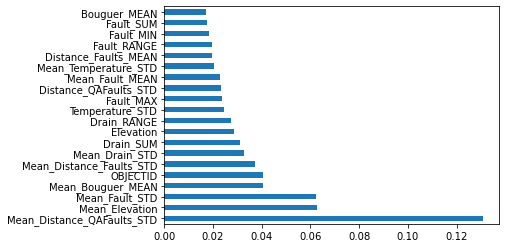

In [253]:
feat_importances = pd.Series(Regressor.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')

In [88]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(Regressor, random_state=1).fit(X, Y)
eli5.show_weights(perm, feature_names = X.columns.tolist(), top=20)

Weight,Feature
0.2288 ± 0.0849,Mean_Distance_QAFaults_STD
0.0610 ± 0.0349,Mean_Elevation
0.0539 ± 0.0074,Mean_Fault_STD
0.0428 ± 0.0154,OBJECTID
0.0338 ± 0.0111,Mean_Bouguer_MEAN
0.0319 ± 0.0048,Mean_Drain_STD
0.0281 ± 0.0118,Mean_Distance_Faults_STD
0.0254 ± 0.0072,Drain_SUM
0.0229 ± 0.0038,Drain_RANGE
0.0208 ± 0.0093,Elevation


In [106]:
i = permutation_importance(Regressor, X, Y, random_state=1)

<AxesSubplot:>

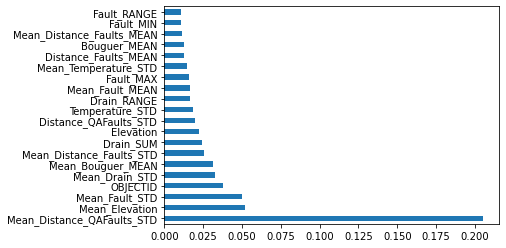

In [107]:
feat_importancesa = pd.Series(i.importances_mean, index=X.columns)
feat_importancesa.nlargest(20).plot(kind='barh')

## SelectFromModel

In [84]:
model = SelectFromModel(Regressor, prefit=True)
X_new = model.transform(X)

C:\Users\mathe\anaconda3\envs\Teste_Tensor\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


In [85]:
X_new.shape

(107, 40)

In [17]:
Regressor_new = RandomForestRegressor(criterion='squared_error', max_depth=5, min_samples_leaf=2, min_samples_split=2,
                                  n_estimators=250, random_state=2)
Regressor_new.fit(X_new, Y)
predict_new = Regressor_new.predict(X_new)

### K fold CV

In [18]:
k = 5
kf = KFold(n_splits=k)
 
result = cross_val_score(Regressor_new , X_new, Y, cv = kf, scoring='r2')
 
print("Avg accuracy: {}".format(result.mean()))

Avg accuracy: 0.21519165180610758


In [19]:
k = 5
kf = KFold(n_splits=k)
 
result = cross_val_score(Regressor_new , X_new, Y, cv = kf, scoring='neg_mean_absolute_error')
 
print("Avg accuracy: {}".format(result.mean()))

Avg accuracy: -3.6688707898278516


In [20]:
k = 5
kf = KFold(n_splits=k)
 
result = cross_val_score(Regressor_new , X_new, Y, cv = kf, scoring='neg_mean_squared_error')
 
print("Avg accuracy: {}".format(result.mean()))
rmse = math.sqrt(-result.mean())
rmse

Avg accuracy: -22.15381522069949


4.706783957300302

### Grid Search CV

In [186]:
rf_grid = GridSearchCV(estimator=Regressor_new, param_grid=param_grid, cv=5)
rf_grid.fit(X_new, Y)

GridSearchCV(cv=5,
             estimator=RandomForestRegressor(max_depth=5, min_samples_leaf=2,
                                             n_estimators=250, random_state=2),
             param_grid={'criterion': ['absolute_error', 'squared_error'],
                         'max_depth': [5, 8, 10, 12, 15],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 3],
                         'n_estimators': [100, 200, 250, 500],
                         'random_state': [2, 3, 4]})

In [187]:
rf_grid.best_params_

{'criterion': 'squared_error',
 'max_depth': 5,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 250,
 'random_state': 2}

# Model - Heat flux density

In [21]:
selected_rows = dataset[~dataset["Grad_Geot"].isnull()]

In [22]:
XX = pd.DataFrame((selected_rows.drop([ "gridcode", "Shape_Length", "Shape_Area", "HFD", "Grad_Geot", "Count of Points" ], axis=1)))
YY = (selected_rows["HFD"])

In [23]:
YY_mean, YY_std = mean(YY), std(YY)
# identify outliers
cut_off = YY_std * 3
lower, upper = YY_mean - cut_off, YY_mean + cut_off
# identify outliers
outliers = [x for x in YY if x < lower or x > upper]
print('Identified outliers: %d' % len(outliers))
# remove outliers
outliers_removed = [x for x in YY if x >= lower and x <= upper]
print('Non-outlier observations: %d' % len(outliers_removed))
print(outliers)

Identified outliers: 1
Non-outlier observations: 108
[183.84]


In [24]:
selected_rows = dataset[~dataset["HFD"].isnull()]

In [25]:
FinalData = selected_rows[~selected_rows['HFD'].isin(outliers)]

In [26]:
XX = pd.DataFrame((FinalData.drop([ "gridcode", "Shape_Length", "Shape_Area", "HFD", "Grad_Geot", "Count of Points" ], axis=1)))
YY = (FinalData["HFD"])

In [27]:
YY.shape

(108,)

In [64]:
YY.describe()

count    108.000000
mean      62.304904
std       18.095066
min       25.000000
25%       50.441450
50%       60.916100
75%       72.304250
max      116.650000
Name: HFD, dtype: float64

In [197]:
min_max_scaler = MinMaxScaler()
min_max_scaler.fit(XX)
min_max_scaler.transform(XX)

array([[0.66422785, 0.09842883, 0.44444444, ..., 0.60377942, 0.27332722,
        0.        ],
       [0.65769532, 0.31855181, 0.44444444, ..., 0.79261732, 0.11736909,
        0.85641825],
       [0.93180037, 0.71563003, 0.        , ..., 0.80007708, 0.02989396,
        0.61998086],
       ...,
       [0.98771884, 0.48245866, 0.44444444, ..., 0.75243299, 0.41655044,
        0.86958356],
       [0.11314345, 0.72479081, 0.        , ..., 0.7022979 , 0.17424251,
        0.61936965],
       [0.87143977, 0.79988242, 0.44444444, ..., 0.79990845, 0.08708589,
        0.99811906]])

In [28]:
Regressor2 = RandomForestRegressor(criterion='absolute_error', max_depth=10, min_samples_leaf=1, min_samples_split=2,
                                  n_estimators=250, random_state=4)
Regressor2.fit(XX, YY)
pred_Regressor = Regressor2.predict(XX)

In [29]:
k = 5
kf = KFold(n_splits=k)
result = cross_val_score(Regressor2 , XX, YY, cv = kf)
print (result.mean())

0.2213234958350438


In [30]:
k = 5
kf = KFold(n_splits=k)
result = cross_val_score(Regressor2 , XX, YY, cv = kf, scoring='neg_mean_absolute_error')
print (result.mean())

-12.38395917180375


In [31]:
k = 5
kf = KFold(n_splits=k)
result = cross_val_score(Regressor2 , XX, YY, cv = kf, scoring='neg_mean_squared_error')
print (result.mean())
rmse = math.sqrt(-result.mean())
rmse

-235.27528118107193


15.338685770986768

In [203]:
rf_grid = GridSearchCV(estimator=Regressor2, param_grid=param_grid, cv=5)
rf_grid.fit(XX, YY)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'criterion': ['absolute_error', 'squared_error'],
                         'max_depth': [5, 8, 10, 12, 15],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 3],
                         'n_estimators': [100, 200, 250, 500],
                         'random_state': [2, 3, 4]})

In [204]:
rf_grid.best_params_

{'criterion': 'absolute_error',
 'max_depth': 10,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 250,
 'random_state': 4}

### Select from model 

In [32]:
model2 = SelectFromModel(Regressor2, prefit=True)
X_new2 = model2.transform(XX)

C:\Users\mathe\anaconda3\envs\Teste_Tensor\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


In [86]:
X_new2.shape

(108, 59)

In [65]:
Regressor_new2 = RandomForestRegressor(criterion='absolute_error', max_depth=15, min_samples_leaf=1, min_samples_split=3,
                                  n_estimators=200, random_state=2)
Regressor_new2.fit(X_new2, YY)
predict_new2 = Regressor_new2.predict(X_new2)

In [66]:
df = pd.DataFrame({'Feature_names' : X.columns, 'Importances' : Regressor2.feature_importances_})

print(df.sort_values(by='Importances', ascending=False).nlargest(100, 'Importances'))

                                         Feature_names  Importances
104                                            point_Y     0.070020
239                         Mean_Distance_QAFaults_STD     0.041811
0                                             OBJECTID     0.040844
237                           Mean_Distance_Faults_STD     0.034724
32                                           Drain_SUM     0.033345
..                                                 ...          ...
210  MAX_ONEHOT_Descricao1_Rochas_magm_ticas_intrus...     0.001519
69                     ONEHOT_Zona_Cobertura_Cenoz_ica     0.001491
45                                           Texture_2     0.001443
72                         ONEHOT_Sistema_Desconhecido     0.001410
135  MAX_ONEHOT_Descricao1_Cret_cico_Inferior_da_Or...     0.001350

[100 rows x 2 columns]


In [90]:
perm = PermutationImportance(Regressor2, random_state=1).fit(XX, YY)
eli5.show_weights(perm, feature_names = X.columns.tolist(), top=20)

Weight,Feature
0.0977 ± 0.0205,point_Y
0.0429 ± 0.0107,Mean_Distance_QAFaults_STD
0.0393 ± 0.0130,OBJECTID
0.0320 ± 0.0045,Drain_SUM
0.0302 ± 0.0083,Texture_3
0.0292 ± 0.0085,Distance_QAFaults_STD
0.0270 ± 0.0044,Mean_Distance_Faults_STD
0.0215 ± 0.0039,Drain_RANGE
0.0209 ± 0.0065,MAX_ONEHOT_Descricao1_Faixa_Piritosa
0.0178 ± 0.0069,Fault_MIN


<AxesSubplot:>

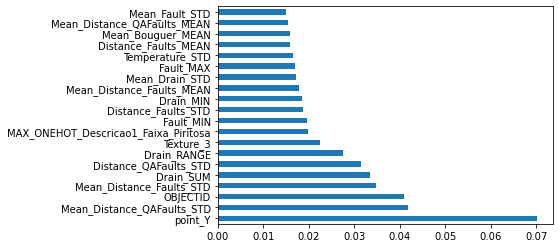

In [91]:
feat_importances2 = pd.Series(Regressor2.feature_importances_, index=X.columns)
feat_importances2.nlargest(20).plot(kind='barh')

In [103]:
e= permutation_importance(Regressor2, XX, YY, random_state=1)
sorted_idx = e.importances_mean.argsort().

fig, ax = plt.subplots()
ax.boxplot(
    e.importances[sorted_idx].T, vert=False, labels=XX.columns[sorted_idx]
)
ax.set_title("Permutation Importances")
fig.tight_layout()
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'nlargest'

<AxesSubplot:>

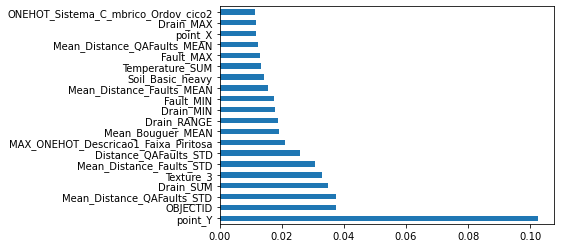

In [105]:
feat_importances2 = pd.Series(e.importances_mean, index=XX.columns)
feat_importances2.nlargest(20).plot(kind='barh')

In [67]:
k = 5
kf2 = KFold(n_splits=k)
 
result = cross_val_score(Regressor_new2 , X_new2, YY, cv = kf2)
 
print("Avg accuracy: {}".format(result.mean()))

Avg accuracy: 0.24832842067503483


In [68]:
k = 5
kf2 = KFold(n_splits=k)
 
result = cross_val_score(Regressor_new2 , X_new2, YY, cv = kf2, scoring='neg_mean_absolute_error')
 
print("Avg accuracy: {}".format(result.mean()))

Avg accuracy: -12.067700100342714


In [69]:
k = 5
kf2 = KFold(n_splits=k)
 
result = cross_val_score(Regressor_new2 , X_new2, YY, cv = kf2, scoring='neg_mean_squared_error')
 
print("Avg accuracy: {}".format(result.mean()))
rmse = math.sqrt(-result.mean())
rmse

Avg accuracy: -225.9886853795577


15.032920054984583

In [220]:
rf_grid = GridSearchCV(estimator=Regressor_new2, param_grid=param_grid, cv=5)
rf_grid.fit(X_new2, YY)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'criterion': ['absolute_error', 'squared_error'],
                         'max_depth': [5, 8, 10, 12, 15],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 3],
                         'n_estimators': [100, 200, 250, 500],
                         'random_state': [2, 3, 4]})

In [221]:
rf_grid.best_params_

{'criterion': 'absolute_error',
 'max_depth': 15,
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'n_estimators': 200,
 'random_state': 2}

## Predict Full Data

In [79]:
full_data = pd.read_csv("Table_5x5_Final.csv")
X_full = (full_data.drop(["gridcode", "Shape_Length", "Shape_Area", "HFD", "Grad_Geot", "Count of Points" ], axis=1))
Y_full = (full_data["Grad_Geot"])
X_full.shape

(3830, 242)

In [80]:
X_full = model2.transform(X_full)

C:\Users\mathe\anaconda3\envs\Teste_Tensor\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


In [81]:
predict_full = Regressor_new2.predict(X_full)
predict_full

array([61.54776317, 64.04842967, 67.62396237, ..., 66.0254585 ,
       57.22105679, 79.68378196])

In [82]:
predict_full = pd.DataFrame(predict_full)
predict_full.describe()

,0
count,3830.000000
mean,63.352276
std,7.156823
min,32.784473
25%,59.032401
50%,62.972866
75%,67.052845
max,104.956574


In [83]:
prediction = pd.DataFrame(predict_full).to_excel("RF_5x5_Selected_outliersout_hfd.xlsx")

## Saved codes

n_estimators_range = range(10,1000)
n_est_scores = []
for n in n_estimators_range: 
    rf = RandomForestRegressor(n_estimators= n, random_state=2, min_samples_leaf=3)
    scores = cross_val_score(rf, X, Y, cv=5)
    n_est_scores.append(scores.mean())

%matplotlib inline
plt.plot(n_estimators_range, n_est_scores)